<a href="https://colab.research.google.com/github/alexquar/Pytorch-Learning/blob/main/improvedNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#imports
import torch as pt
import torch.nn as nn
import torch.nn.functional as f
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [20]:
#class inherited from nn
class Model(nn.Module):
  #Input layer (flower features) -->
  #layer1 -->
  #layer 2 -->
  #so on...
  #output layer
  def __init__(self, in_features=4, h1=8, h2=9, out_features=3 ):
      super().__init__()
      #layer 1
      self.fc1 = nn.Linear(in_features, h1)
      #layer 2
      self.fc2 = nn.Linear(h1,h2)
      #output layer
      self.out = nn.Linear(h2, out_features)
  def forward(self ,x ):
    #function pushes through all layers and returns output
    #relu is a pt function that basically says if something is less than 0 let it be 0 in short
    x = f.relu(self.fc1(x))
    x = f.relu(self.fc2(x))
    x = self.out(x)
    return x


In [47]:
pt.manual_seed(41)

model = Model()

In [54]:
%matplotlib inline
#data set url
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv'
#load pandas data frame
full_df = pd.read_csv(url)
#swap types with numbers for efficiency
full_df['species'] = full_df['species'].replace('setosa',0.0).replace('versicolor', 1.0).replace('virginica',2.0)


full_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [55]:
#training and testing

#drop species column and also get a species column
partial_df = full_df.drop('species', axis=1)
species_df = full_df['species']

#convert to numpy arr
X = partial_df.values
Y = species_df.values

#get training set, test set, labels determine how much for each via test_size and set a base random
#basically splits all our data to test and training sets with test and train answers
X_train , X_test , Y_train , Y_test = train_test_split(X,Y,test_size=.2,random_state=42)


#converts our data and answers for test and train to tensors with are easier to work with for NN

#convert X to tensors
X_train = pt.FloatTensor(X_train)
X_test = pt.FloatTensor(X_test)

#convert Y to tensors
Y_train = pt.LongTensor(Y_train)
Y_test = pt.LongTensor(Y_test)


In [56]:
#set the criterion of model to measure the error, how far our predictions are from expected result

#we will use this method for this nn
criterion = nn.CrossEntropyLoss()

#choose optimizer and learning rate, this one will use Adam. lr is if error rate does not go down after iterations then the lr might need to be lowered, the lower the lr the longer training time will be
optimizer = pt.optim.Adam(model.parameters(), lr=0.01) #parameters are just the things we set on our model ie our layers, 1,2,out


In [63]:
#run iterations and trck error
iterations = 100
losses = []
for i in range(iterations):
  Y_pred = model.forward(X_train) #send forward training data

  #measure error, will be high originally, test results against correct answers based on criterion method we chose
  loss = criterion(Y_pred, Y_train)

  #add to our losses to track improvement
  losses.append(loss.detach().numpy())

  #print loss every ten iterations to check progress
  if i%10 == 0:
    print(f'iteration:{i}, loss:{loss}')

  #back propegation: as you get error rates you feed it back into the model for the next iteration so that weights can be adjusted accordingly to fine tune
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

iteration:0, loss:0.28254783153533936
iteration:10, loss:0.19306634366512299
iteration:20, loss:0.13670380413532257
iteration:30, loss:0.10248851776123047
iteration:40, loss:0.08341799676418304
iteration:50, loss:0.07271778583526611
iteration:60, loss:0.0664980337023735
iteration:70, loss:0.06266852468252182
iteration:80, loss:0.060147520154714584
iteration:90, loss:0.05838574096560478


Text(0.5, 0, 'iteration')

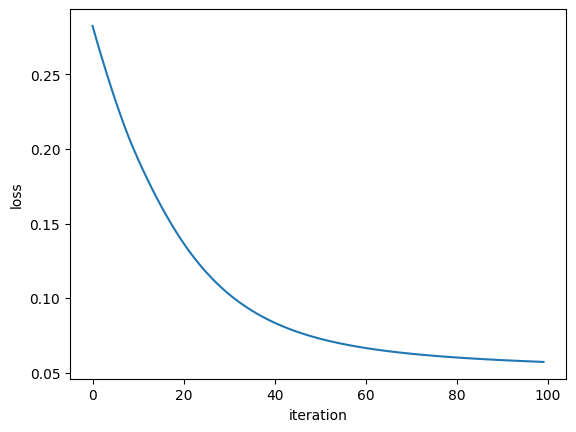

In [64]:
#graph error, goes through range of iterations and matches that with loss in our list
plt.plot(range(iterations), losses)
plt.ylabel("loss")
plt.xlabel("iteration")

In [62]:
#evaluate nn on our test data now that we have trained on training data
with pt.no_grad(): #turns of back propagation
  Y_eval = model.forward(X_test) #forward test data
  loss_test = criterion(Y_eval, Y_test)
print(loss_test)

correct = 0
with pt.no_grad():
  for i, data in enumerate(X_test):
    Y_val = model.forward(data)
    #check if answer is correct
    if Y_val.argmax().item() == Y_test[i]:
      correct+=1
print(f'we have {correct} out of 30')

tensor(0.2718)
we have 29 out of 30


In [77]:
#feed new data
with pt.no_grad():
  new_flower = pt.tensor([1.7,1.2,1.3,0.6])
  print(model(new_flower))

tensor([ 0.7535,  1.3802, -1.2503])


In [78]:
#save model
pt.save(model.state_dict(), 'flower_class_model.pt')

In [79]:
#load saved model
new_model = Model()
new_model.load_state_dict(pt.load('flower_class_model.pt'))
new_model.eval()

<ipython-input-79-cdce375841e4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(pt.load('flower_class_model.pt'))


Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)